In [1]:
#Imports
import os
import copy
import sys
import csv
from sigfig import round
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy 
import netCDF4
from shapely.geometry import Point, LineString, MultiPoint
from scipy.interpolate import griddata
import scipy.interpolate
import scipy
import cmocean
from sklearn import datasets, preprocessing
from eofs.standard import Eof                              #EOFs!!
from eofs.multivariate.standard import MultivariateEof
from scipy import stats

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/')
#Import custom functions
from read_CTD import read_CTD    #To read CTD files
from out_outliers import out_outliers     #To replace outliers
import plotting_functions as plot   #To plot vertical profiles, T-S and vertical sections
from maps import mapa, map_layers    #To plot maps
from stations import stations
from transsects import select_transsects
from dict_units import dict_units

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/distance')
from distances import *

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/transsects_functions/')
from bathymetry_transsects import bathymetry_transsects
from transsect_distances import transsect_distances
from transsects_dataconc import transsects_dataconc

from matplotlib.colors import Normalize
class PiecewiseNorm(Normalize):
    def __init__(self, levels, clip=False):
        # the input levels
        self._levels = np.sort(levels)
        # corresponding normalized values between 0 and 1
        self._normed = np.linspace(0, 1, len(levels))
        Normalize.__init__(self, None, None, clip)

    def __call__(self, value, clip=None):
        # linearly interpolate to get the normalized value
        return np.ma.masked_array(np.interp(value, self._levels, self._normed))
    
#To turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Select properties for the analysis

#Transsects
transsects_selected = [1,2,3,4,5,6]

#Remove the surface layer to make the analysis (False or meters to remove)
#surf_layer_out = False
surf_layer_out = 58

#variables
variables = ['temperature','salinity','oxygen']

#Save plots (False or the folder path)
path = False
#path = 'C:/Users/pauab/Universidad/TFM/Figuras/EOF/'

In [3]:
#Data reading and outlier replacement
data_dirs = ['C:/Users/pauab/Universidad/Data/TFM/CTD_recalc/']
data=read_CTD(data_dirs)

for ncast in data.keys():
    for variable in data[ncast].columns:
        out_outliers(data, ncast, variable)
    data[ncast]['pressure'] = data[ncast].index
    #data[ncast].index = np.arange(0, len(data[ncast].index))

#Dict with all transsects
all_transsects = {'transsect_0':['15','12','13','14'],
                  'transsect_1':['19','18','17','16'],
                  'transsect_2':['24','23','22','21'],
                  'transsect_3':['26','27','28','29'],
                  'transsect_4':['31','32','33','34'],
                  'transsect_5':['38','37','36','35'],
                  'transsect_6':['43','44','45','46']}

#Dict with the stations grouped according to its position
all_stations_grouped = {}
for i in range(len(list(all_transsects.values())[0])):
    key = 'stations_'+str(i+1)
    all_stations_grouped[key]=[]
    for transsect in all_transsects.values():
        all_stations_grouped[key].append(transsect[i])

In [4]:
#Import a dictionary with the units of the variables
units = dict_units(variables)

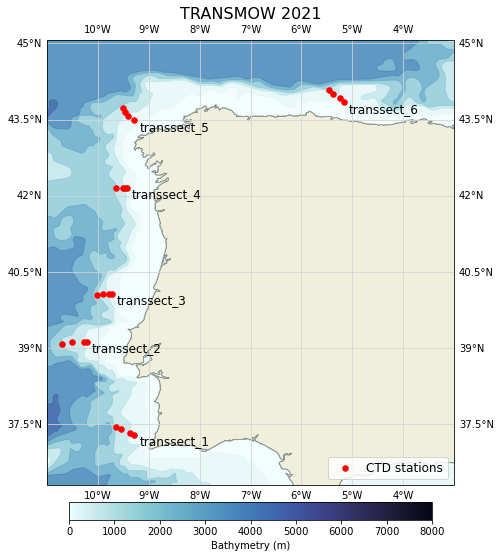

In [5]:
transsects_ncast, stations_grouped = select_transsects(all_transsects, transsects_selected)

#Map the transsects
path = 'C:/Users/pauab/Universidad/TFM/Figuras/maps/'

ncasts = np.array(list(transsects_ncast.values())).reshape(len(transsects_ncast)*len(stations_grouped))
mapa(data, ncasts, labels=False, xoffset=2, yoffset=1, transsects=transsects_ncast, xlim=(-11,-3), savefig=False, path=path)

In [6]:
#Erase the surface layer to avoid noise into the analysis of the water masses
if surf_layer_out != False:
    for ncast in data.keys():
        data[ncast] = data[ncast].loc[surf_layer_out:]

#Extract the reference depth for each station
#We will cut the CTD datasets according to the reference depth for each station
ref_deps={} 
for i in range(len(stations_grouped)):   #iterate over number of transsect stations
    dep_trans=[]
    for ncasts in transsects_ncast.values():
        dep=len(data[ncasts[i]].index)
        dep_trans.append(dep)
    key=str('station_'+str(i))
    ref_deps[key]=min(dep_trans)
print(ref_deps)

list_refdeps = list(ref_deps.values())

## Limiting the CTD datasets to the reference depths established
i = 0
for ncasts in stations_grouped.values():
    for ncast in ncasts:
        data[ncast]=data[ncast].iloc[0:list_refdeps[i]]
    i+=1

{'station_0': 1736, 'station_1': 1319, 'station_2': 916, 'station_3': 400}


In [81]:
variable = 'salinity'

transsect_values = {}
for transsect in transsects_ncast.keys():
    ncasts = transsects_ncast[transsect]
    vector_transsect = []
    for ncast in ncasts:
        values_stat = list(data[ncast][variable].values)
        for value in values_stat:
            vector_transsect.append(value)
    transsect_values[transsect] = vector_transsect

npoints = sum(list_refdeps)
ntrans = len(list(transsects_ncast.keys()))

data_eofs = np.zeros(shape = (ntrans, npoints))
for i in range(ntrans):
    transsect = list(transsects_ncast.keys())[i]
    data_eofs[i,:] = transsect_values[transsect]
    
#Standardize
vector_data = np.reshape(data_eofs, newshape=(ntrans*npoints))
mean_data = np.mean(vector_data)
std_data = np.std(vector_data)

data_eofs_std = (data_eofs - mean_data)/std_data

print(variable, ' - standardized data')
print('mean='+str(round(np.nanmean(data_eofs_std),2)))
print('std='+str(round(np.nanstd(data_eofs_std),2)))
print()

salinity  - standardized data
mean=1.8e-14
std=1.0



In [82]:
solver = Eof(data_eofs, center=False)

neofs = 3
# Retrieve the n_leading EOF
eof = solver.eofs(neofs=neofs, eofscaling=0)
#Variances of the EOFs
variances = np.around(solver.varianceFraction(neigs=neofs)*100,2)
#pcseries
pc = solver.pcs(pcscaling=1, npcs=neofs)

for i in range(len(variances)):
    print('variance of the EOF nº ',str(i+1),' = ',variances[i],'%')

variance of the EOF nº  1  =  100.0 %
variance of the EOF nº  2  =  0.0 %
variance of the EOF nº  3  =  0.0 %


In [83]:
dist = np.linspace(0,1,4)

eof_plot = {}
for a in range(4):
    key = 'station_'+str(a)
    eof_plot[key] = {}
    
    ref_dep = list_refdeps[a]
    if a == 0:
        eof_stat_values = eof[0][0:ref_dep]
    else:
        from_=sum(list_refdeps[0:a])
        to = from_ + list_refdeps[a]
        eof_stat_values = eof[0][from_:to]
        
    eof_plot[key]['eof'] = eof_stat_values
    eof_plot[key]['x'] = [dist[a]]*list_refdeps[a]
    eof_plot[key]['depth'] = np.linspace(0, list_refdeps[a]-1, list_refdeps[a])

data_conc = pd.DataFrame(dtype='float64')
for a in range(4):
    key = 'station_'+str(a)
    dic = {'eof':eof_plot[key]['eof'],
           'x':eof_plot[key]['x'],
           'depth':eof_plot[key]['depth']
          }
    df = pd.DataFrame(dic)
    if data_conc.empty:
        data_conc = df
    else:
        data_conc = pd.concat([data_conc, df])

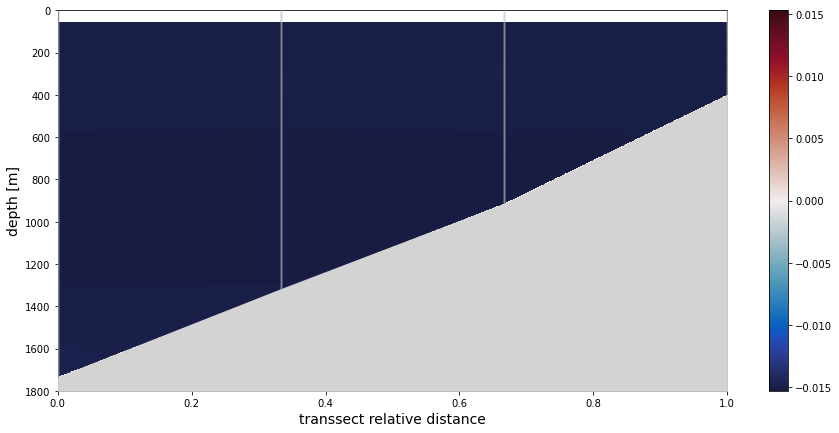

In [84]:
#variable = 'oxygen'
ieof = 'eof1'
interpolation = 'linear'
xoffset = 0.1
fontsize_title = 20
fontsize_label = 14
cmap = cmocean.cm.balance

#Plotting
fig, ax0 = plt.subplots(1,1, figsize = (15,7))

#Axis limits
ax0.set_xlim(0, 1)
ax0.set_ylim(1800, 0)
ax0.margins(0.05)

dist = np.linspace(0,1,4)
plt.fill_between(dist, list_refdeps, 1800, color='lightgray', zorder=99)

#interp = scipy.interpolate.Rbf(data_conc['x'], data_conc['depth'], data_conc['eof'], function='linear')
#xi, yi = np.mgrid[0:1:50j, surf_layer_out:1750:50j]
#zi = interp(xi, yi)
##handle1 = ax0.contourf(xi, yi, zi, cmap=cmap, norm=PiecewiseNorm(levels), levels=100)
#handle1 = ax0.contourf(xi, yi, zi, cmap=cmap, levels=100)
##CS = ax0.contour(xi, yi, zi, colors=['white','k','k','k'], linewidths=0.75, levels=clevels)

#vmin = data_conc['eof'].min()
#vmax = data_conc['eof'].max()

#If we want the white color to be the 0 value, we have to adjust the properties of the color bar (adjust the maxs and minimums values)
if abs(np.nanmax(data_conc['eof'])) > abs(np.nanmin(data_conc['eof'])):            #in case the absolute highest value is positive
    vmax, vmin = np.nanmax(data_conc['eof']), -np.nanmax(data_conc['eof'])
else:                                                #in case the absolute highest value is negative
    vmax, vmin = -np.nanmin(data_conc['eof']), np.nanmin(data_conc['eof'])
    
points = list(zip(data_conc['x'], data_conc['depth']))
xi, yi = np.mgrid[0:1:1000j, surf_layer_out:1750:1000j]
grid_ztest = griddata(points, data_conc['eof'], (xi, yi), method='linear', rescale=True )
#handle1 = ax0.pcolormesh(xi, yi, grid_ztest, norm=PiecewiseNorm(levels), cmap=cmap, shading='auto')
handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')

clevels = [0]
CS = ax0.contour(xi, yi, grid_ztest, colors=['k','k','k'], linewidths=0.75, levels=clevels)

#Ploting the CTD stations cast
b = ax0.scatter(data_conc['x'], data_conc['depth'], alpha=0.06, c='lightgrey', s=2, zorder=120)

#Contours
ax0.clabel(CS, CS.levels, inline=True, fmt='%1.2f', fontsize=fontsize_label)

#Colorbar
cb = fig.colorbar(handle1, ax=ax0)
#cb.set_label(label=variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)

#titles
plt.ylabel('depth [m]', fontsize=fontsize_label)
plt.xlabel('transsect relative distance', fontsize=fontsize_label)

plt.show()

In [85]:
dist = np.linspace(0,1,4)

eof_plot = {}
for a in range(4):
    key = 'station_'+str(a)
    eof_plot[key] = {}
    
    ref_dep = list_refdeps[a]
    if a == 0:
        eof_stat_values = eof[1][0:ref_dep]
    else:
        from_=sum(list_refdeps[0:a])
        to = from_ + list_refdeps[a]
        eof_stat_values = eof[1][from_:to]
        
    eof_plot[key]['eof'] = eof_stat_values
    eof_plot[key]['x'] = [dist[a]]*list_refdeps[a]
    eof_plot[key]['depth'] = np.linspace(0, list_refdeps[a]-1, list_refdeps[a])

data_conc = pd.DataFrame(dtype='float64')
for a in range(4):
    key = 'station_'+str(a)
    dic = {'eof':eof_plot[key]['eof'],
           'x':eof_plot[key]['x'],
           'depth':eof_plot[key]['depth']
          }
    df = pd.DataFrame(dic)
    if data_conc.empty:
        data_conc = df
    else:
        data_conc = pd.concat([data_conc, df])

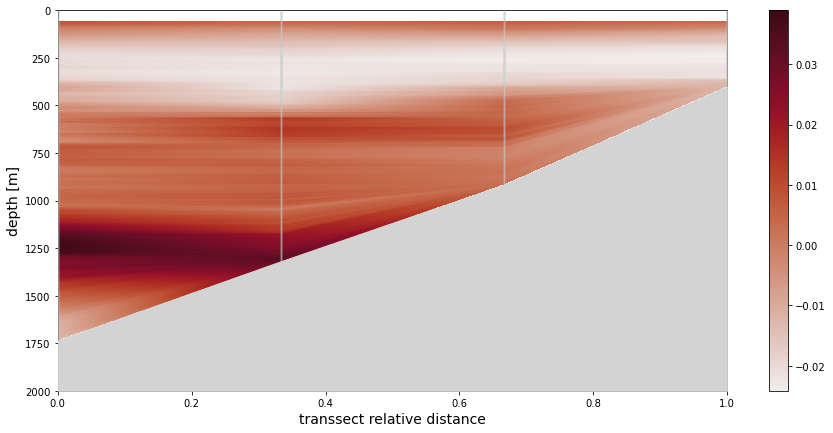

In [86]:
#variable = 'oxygen'
#ieof = 'eof1'
interpolation = 'linear'
xoffset = 0.1
fontsize_title = 20
fontsize_label = 14
cmap = cmocean.cm.amp

#Plotting
fig, ax0 = plt.subplots(1,1, figsize = (15,7))

#Axis limits
ax0.set_xlim(0, 1)
ax0.set_ylim(2000, 0)
ax0.margins(0.05)

dist = np.linspace(0,1,4)
plt.fill_between(dist, list_refdeps, 2000, color='lightgray', zorder=99)

#interp = scipy.interpolate.Rbf(data_conc['x'], data_conc['depth'], data_conc['eof'], function='linear')
#xi, yi = np.mgrid[0:1:50j, surf_layer_out:1750:50j]
#zi = interp(xi, yi)
##handle1 = ax0.contourf(xi, yi, zi, cmap=cmap, norm=PiecewiseNorm(levels), levels=100)
#handle1 = ax0.contourf(xi, yi, zi, cmap=cmap, levels=100)
##CS = ax0.contour(xi, yi, zi, colors=['white','k','k','k'], linewidths=0.75, levels=clevels)

vmin = data_conc['eof'].min()
vmax = data_conc['eof'].max()

#If we want the white color to be the 0 value, we have to adjust the properties of the color bar (adjust the maxs and minimums values)
#if abs(np.nanmax(data_conc['eof'])) > abs(np.nanmin(data_conc['eof'])):            #in case the absolute highest value is positive
#    vmax, vmin = np.nanmax(data_conc['eof']), -np.nanmax(data_conc['eof'])
#else:                                                #in case the absolute highest value is negative
#    vmax, vmin = -np.nanmin(data_conc['eof']), np.nanmin(data_conc['eof'])
    
points = list(zip(data_conc['x'], data_conc['depth']))
xi, yi = np.mgrid[0:1:1000j, surf_layer_out:1750:1000j]
grid_ztest = griddata(points, data_conc['eof'], (xi, yi), method='linear', rescale=True )
#handle1 = ax0.pcolormesh(xi, yi, grid_ztest, norm=PiecewiseNorm(levels), cmap=cmap, shading='auto')
handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
#CS = ax0.contour(xi, yi, grid_ztest, colors=['white','k','k','k'], linewidths=0.75, levels=clevels)

#Ploting the CTD stations cast
b = ax0.scatter(data_conc['x'], data_conc['depth'], alpha=0.06, c='lightgrey', s=2, zorder=120)

#Contours
#ax0.clabel(CS, CS.levels, inline=True, fmt='%1.2f', fontsize=fontsize_label)

#Colorbar
cb = fig.colorbar(handle1, ax=ax0)
#cb.set_label(label=variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)

#titles
plt.ylabel('depth [m]', fontsize=fontsize_label)
plt.xlabel('transsect relative distance', fontsize=fontsize_label)

plt.show()

In [7]:
variables = ['temperature','salinity','oxygen']

dataset_std = {}
for variable in variables:
    
    transsect_values = {}
    for transsect in transsects_ncast.keys():
        ncasts = transsects_ncast[transsect]
        vector_transsect = []
        for ncast in ncasts:
            values_stat = list(data[ncast][variable].values)
            for value in values_stat:
                vector_transsect.append(value)
        transsect_values[transsect] = vector_transsect

    npoints = sum(list_refdeps)
    ntrans = len(list(transsects_ncast.keys()))

    data_eofs = np.zeros(shape = (ntrans, npoints))
    for i in range(ntrans):
        transsect = list(transsects_ncast.keys())[i]
        data_eofs[i,:] = transsect_values[transsect]

    #Standardize
    vector_data = np.reshape(data_eofs, newshape=(ntrans*npoints))
    mean_data = np.mean(vector_data)
    std_data = np.std(vector_data)

    data_eofs_std = (data_eofs - mean_data)/std_data
    
    dataset_std[variable] = data_eofs_std
    
    print(variable, ' - standardized data')
    print('mean='+str(round(np.nanmean(data_eofs_std),2)))
    print('std='+str(round(np.nanstd(data_eofs_std),2)))
    print()

temperature  - standardized data
mean=-2.1e-16
std=1.0

salinity  - standardized data
mean=1.8e-14
std=1.0

oxygen  - standardized data
mean=-1.2e-16
std=1.0



In [8]:
eof_data = {}
for variable in variables:
    
    eof_data[variable] = {}
    
    solver = Eof(dataset_std[variable], center=False)

    neofs = 3
    # Retrieve the n_leading EOF
    eof = solver.eofs(neofs=neofs, eofscaling=1)
    #Variances of the EOFs
    variances = np.around(solver.varianceFraction(neigs=neofs)*100,2)
    #pcseries
    pc = solver.pcs(pcscaling=1, npcs=neofs)
    
    eof_data[variable]['eof_1'] = eof[0]
    eof_data[variable]['eof_2'] = eof[1]
    eof_data[variable]['pcs'] = pc
    eof_data[variable]['variances'] = variances
       
    print(variable)
    for i in range(len(variances)):
        print('variance of the EOF nº ',str(i+1),' = ',variances[i],'%')
    print()

temperature
variance of the EOF nº  1  =  85.66 %
variance of the EOF nº  2  =  13.13 %
variance of the EOF nº  3  =  0.72 %

salinity
variance of the EOF nº  1  =  67.66 %
variance of the EOF nº  2  =  30.35 %
variance of the EOF nº  3  =  0.92 %

oxygen
variance of the EOF nº  1  =  86.85 %
variance of the EOF nº  2  =  11.47 %
variance of the EOF nº  3  =  0.78 %



In [9]:
dist = np.linspace(0,1,4)

eof_plot = {}
for variable in variables:
    
    eof_plot[variable] = {}
    
    for i in range(2):
        key = 'eof_'+str(i+1)
        eof_plot[variable][key] = {}
        
        for a in range(4):
            stat = 'station_'+str(a)
            eof_plot[variable][key][stat] = {}

            ref_dep = list_refdeps[a]
            if a == 0:
                eof_stat_values = eof_data[variable][key][0:ref_dep]
            else:
                from_=sum(list_refdeps[0:a])
                to = from_ + list_refdeps[a]
                eof_stat_values = eof_data[variable][key][from_:to]

            eof_plot[variable][key][stat]['eof'] = eof_stat_values
            eof_plot[variable][key][stat]['x'] = [dist[a]]*list_refdeps[a]
            eof_plot[variable][key][stat]['depth'] = np.linspace(0, list_refdeps[a]-1, list_refdeps[a])

data_plot = {}

for variable in variables:    
    data_plot[variable] = {}
    for i in range(2):
        key = 'eof_'+str(i+1)
        data_plot[variable][key] = {}
        
        data_conc = pd.DataFrame(dtype='float64')
        for a in range(4):
            stat = 'station_'+str(a)
            dic = {'eof':eof_plot[variable][key][stat]['eof'],
                   'x':eof_plot[variable][key][stat]['x'],
                   'depth':eof_plot[variable][key][stat]['depth']
                  }
            df = pd.DataFrame(dic)
            if data_conc.empty:
                data_conc = df
            else:
                data_conc = pd.concat([data_conc, df])
        data_plot[variable][key] = data_conc        

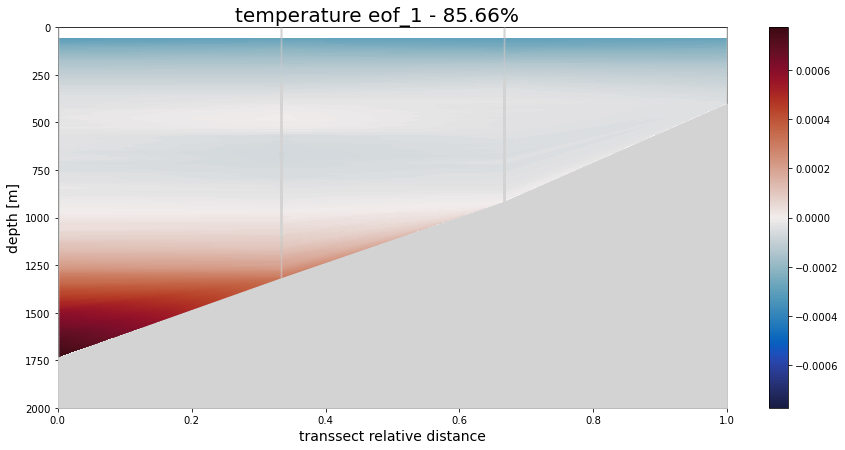

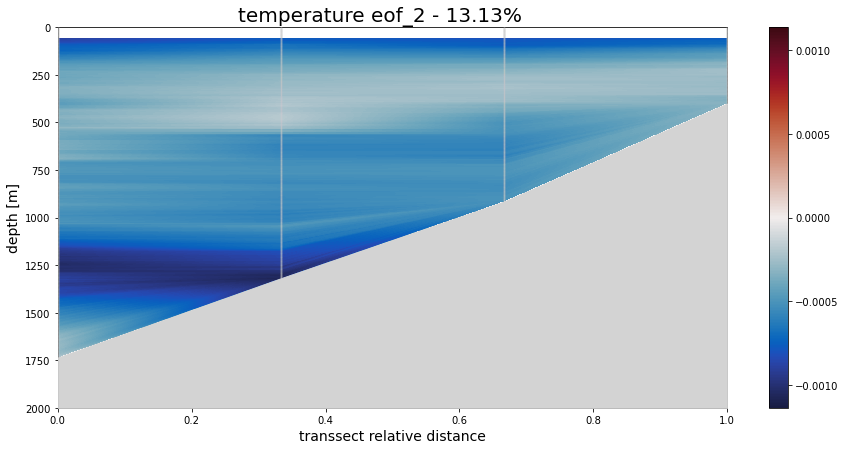

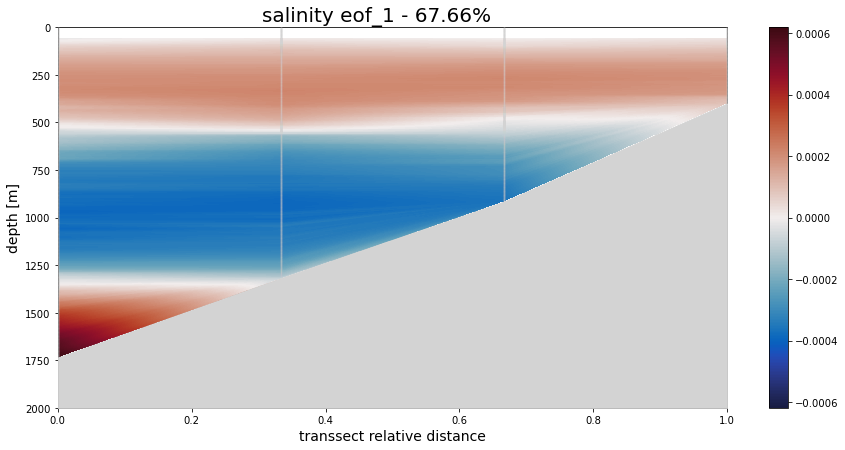

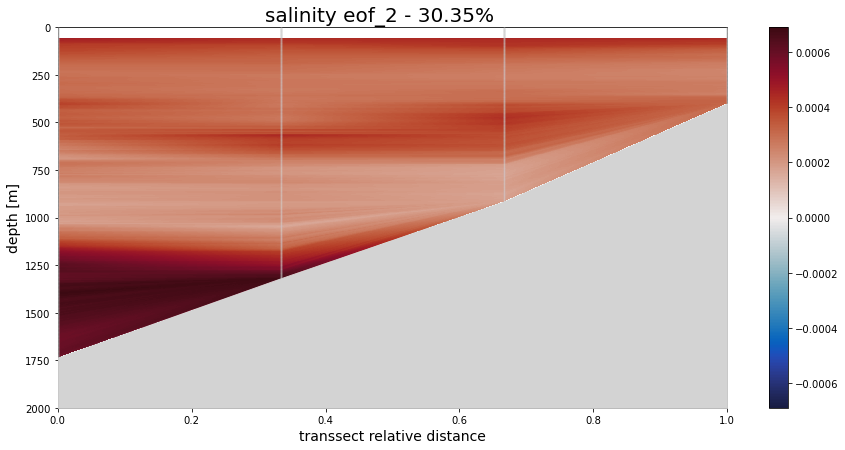

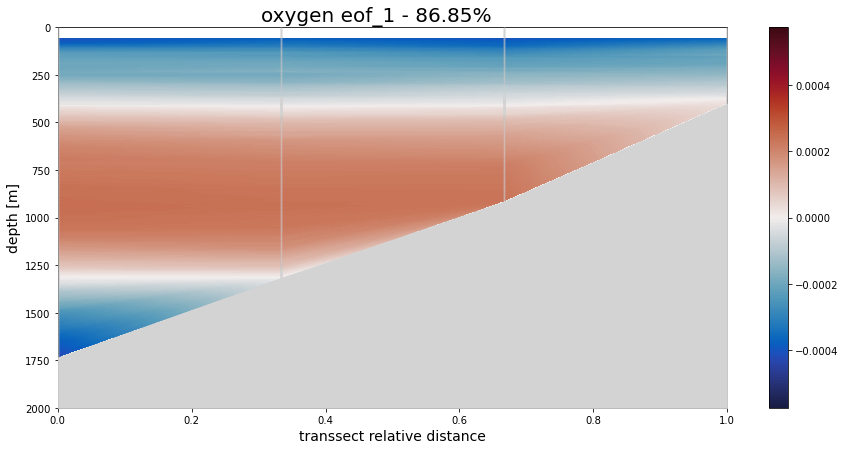

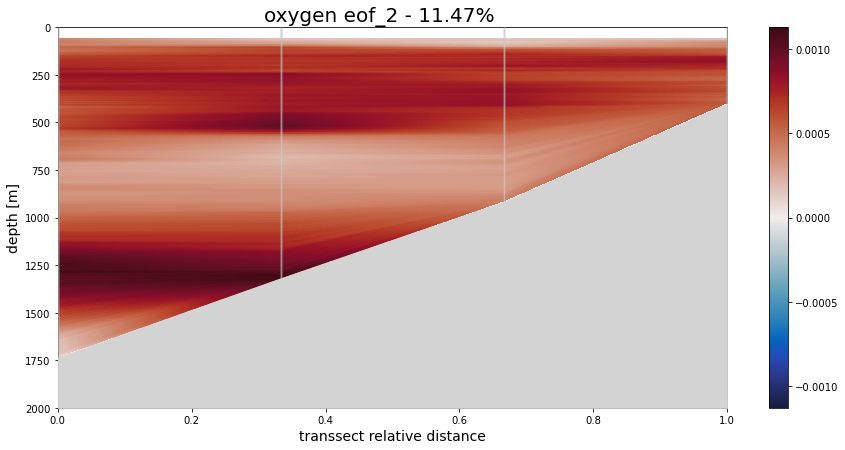

In [10]:
#ieof = 'eof1'
interpolation = 'linear'
xoffset = 0.1
fontsize_title = 20
fontsize_label = 14
cmap = cmocean.cm.balance

for variable in variables:
    
    for i in range(2):
        key = 'eof_'+str(i+1)
        #Plotting
        fig, ax0 = plt.subplots(1,1, figsize = (15,7))

        #Axis limits
        ax0.set_xlim(0, 1)
        ax0.set_ylim(2000, 0)
        ax0.margins(0.05)

        dist = np.linspace(0,1,4)
        plt.fill_between(dist, list_refdeps, 2000, color='lightgray', zorder=99)

        #interp = scipy.interpolate.Rbf(data_conc['x'], data_conc['depth'], data_conc['eof'], function='linear')
        #xi, yi = np.mgrid[0:1:50j, surf_layer_out:1750:50j]
        #zi = interp(xi, yi)
        ##handle1 = ax0.contourf(xi, yi, zi, cmap=cmap, norm=PiecewiseNorm(levels), levels=100)
        #handle1 = ax0.contourf(xi, yi, zi, cmap=cmap, levels=100)
        ##CS = ax0.contour(xi, yi, zi, colors=['white','k','k','k'], linewidths=0.75, levels=clevels)

        #vmin = data_conc['eof'].min()
        #vmax = data_conc['eof'].max()

        #If we want the white color to be the 0 value, we have to adjust the properties of the color bar (adjust the maxs and minimums values)
        if abs(np.nanmax(data_plot[variable][key]['eof'])) > abs(np.nanmin(data_plot[variable][key]['eof'])):            #in case the absolute highest value is positive
            vmax, vmin = np.nanmax(data_plot[variable][key]['eof']), -np.nanmax(data_plot[variable][key]['eof'])
        else:                                                #in case the absolute highest value is negative
            vmax, vmin = -np.nanmin(data_plot[variable][key]['eof']), np.nanmin(data_plot[variable][key]['eof'])

        points = list(zip(data_plot[variable][key]['x'], data_plot[variable][key]['depth']))
        xi, yi = np.mgrid[0:1:1000j, surf_layer_out:1750:1000j]
        grid_ztest = griddata(points, data_plot[variable][key]['eof'], (xi, yi), method='linear', rescale=True )
        #handle1 = ax0.pcolormesh(xi, yi, grid_ztest, norm=PiecewiseNorm(levels), cmap=cmap, shading='auto')
        handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
        #CS = ax0.contour(xi, yi, grid_ztest, colors=['white','k','k','k'], linewidths=0.75, levels=clevels)

        #Ploting the CTD stations cast
        b = ax0.scatter(data_plot[variable][key]['x'], data_plot[variable][key]['depth'], alpha=0.06, c='lightgrey', s=2, zorder=120)

        #Contours
        #ax0.clabel(CS, CS.levels, inline=True, fmt='%1.2f', fontsize=fontsize_label)

        #Colorbar
        cb = fig.colorbar(handle1, ax=ax0)
        #cb.set_label(label=variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)

        #titles
        plt.ylabel('depth [m]', fontsize=fontsize_label)
        plt.xlabel('transsect relative distance', fontsize=fontsize_label)
        if key == 'eof_1':
            plt.title(variable+' '+str(key)+' - '+str(eof_data[variable]['variances'][0])+'%     ',fontsize=20)
        if key == 'eof_2':
            plt.title(variable+' '+str(key)+' - '+str(eof_data[variable]['variances'][1])+'%    ',fontsize=20)
        if key == 'eof_3':
            plt.title(variable+' '+str(key)+' - '+str(eof_data[variable]['variances'][2])+'%  ',fontsize=20)

        plt.show()

In [256]:
data_plot['salinity']['eof_1']['eof']

0     -0.000575
1     -0.000571
2     -0.000564
3     -0.000558
4     -0.000553
         ...   
395    0.000021
396    0.000022
397    0.000024
398    0.000026
399    0.000027
Name: eof, Length: 4371, dtype: float64

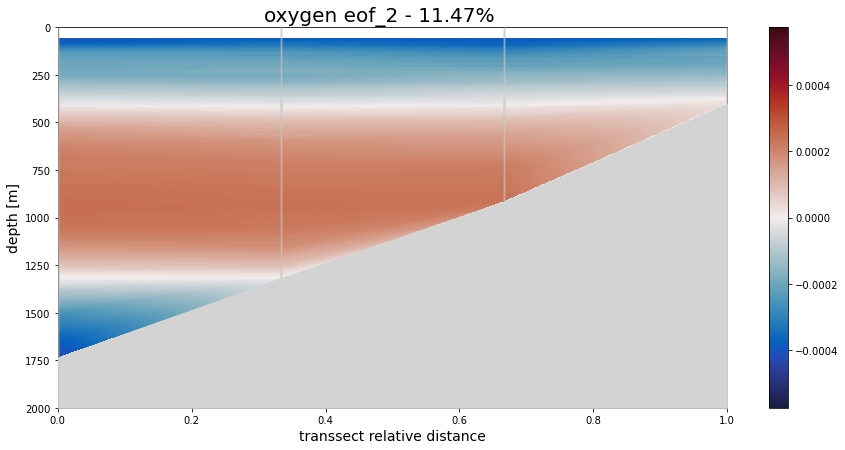

In [252]:
#Plotting
fig, ax0 = plt.subplots(1,1, figsize = (15,7))

#Axis limits
ax0.set_xlim(0, 1)
ax0.set_ylim(2000, 0)
ax0.margins(0.05)

dist = np.linspace(0,1,4)
plt.fill_between(dist, list_refdeps, 2000, color='lightgray', zorder=99)

#interp = scipy.interpolate.Rbf(data_conc['x'], data_conc['depth'], data_conc['eof'], function='linear')
#xi, yi = np.mgrid[0:1:50j, surf_layer_out:1750:50j]
#zi = interp(xi, yi)
##handle1 = ax0.contourf(xi, yi, zi, cmap=cmap, norm=PiecewiseNorm(levels), levels=100)
#handle1 = ax0.contourf(xi, yi, zi, cmap=cmap, levels=100)
##CS = ax0.contour(xi, yi, zi, colors=['white','k','k','k'], linewidths=0.75, levels=clevels)

#vmin = data_conc['eof'].min()
#vmax = data_conc['eof'].max()

#If we want the white color to be the 0 value, we have to adjust the properties of the color bar (adjust the maxs and minimums values)
if abs(np.nanmax(data_plot[variable][key]['eof'])) > abs(np.nanmin(data_plot[variable][key]['eof'])):            #in case the absolute highest value is positive
    vmax, vmin = np.nanmax(data_plot[variable][key]['eof']), -np.nanmax(data_plot[variable][key]['eof'])
else:                                                #in case the absolute highest value is negative
    vmax, vmin = -np.nanmin(data_plot[variable][key]['eof']), np.nanmin(data_plot[variable][key]['eof'])

points = list(zip(data_plot[variable][key]['x'], data_plot[variable][key]['depth']))
xi, yi = np.mgrid[0:1:1000j, surf_layer_out:1750:1000j]
grid_ztest = griddata(points, data_plot[variable][key]['eof'], (xi, yi), method='linear', rescale=True )
#handle1 = ax0.pcolormesh(xi, yi, grid_ztest, norm=PiecewiseNorm(levels), cmap=cmap, shading='auto')
handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
#CS = ax0.contour(xi, yi, grid_ztest, colors=['white','k','k','k'], linewidths=0.75, levels=clevels)

#Ploting the CTD stations cast
b = ax0.scatter(data_plot[variable][key]['x'], data_plot[variable][key]['depth'], alpha=0.06, c='lightgrey', s=2, zorder=120)

#Contours
#ax0.clabel(CS, CS.levels, inline=True, fmt='%1.2f', fontsize=fontsize_label)

#Colorbar
cb = fig.colorbar(handle1, ax=ax0)
#cb.set_label(label=variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)

#titles
plt.ylabel('depth [m]', fontsize=fontsize_label)
plt.xlabel('transsect relative distance', fontsize=fontsize_label)
if key == 'eof_1':
    plt.title(variable+' '+str(key)+' - '+str(eof_data[variable]['variances'][0])+'%     ',fontsize=20)
if key == 'eof_2':
    plt.title(variable+' '+str(key)+' - '+str(eof_data[variable]['variances'][1])+'%    ',fontsize=20)
if key == 'eof_3':
    plt.title(variable+' '+str(key)+' - '+str(eof_data[variable]['variances'][2])+'%  ',fontsize=20)

plt.show()

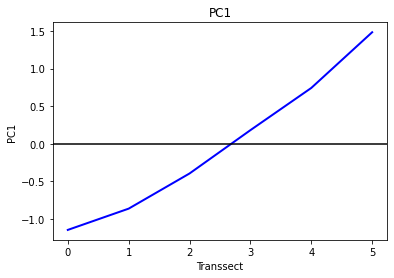

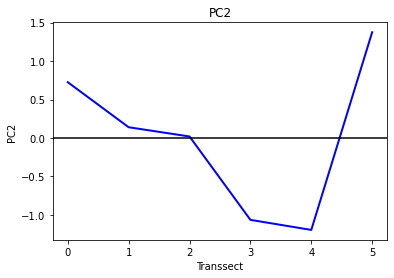

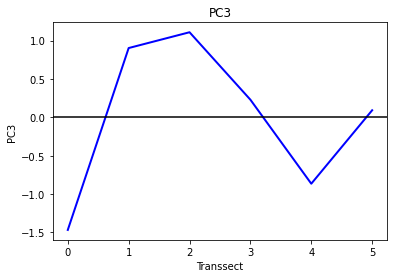

In [136]:
#Plot the PCs
for i in range(neofs):
    ieof = i
    plt.figure()
    plt.plot(np.arange(ntrans), pc[:,ieof], color='b', linewidth=2)
    plt.axhline(0, color='k')
    plt.title('PC'+str(ieof+1))
    plt.xlabel('Transsect')
    plt.ylabel('PC'+str(ieof+1))

In [185]:
cb.

TypeError: 'NoneType' object is not callable

In [163]:
len(eof_stat['station_0'])

1736

In [159]:
sum(list_refdeps[0:2])

3055

In [145]:
len(eof[0][1736:1736+1319])

1319

In [74]:
for transsect in all_transsects.keys():
    print(len(transsect_values[transsect]))

4565
4586
4586
4586
4586
4586
4586


In [76]:
sum(list_refdeps)

4586

In [68]:
len(vector_transsect)

4586

In [69]:
np.zeros?

Docstring:
zeros(shape, dtype=float, order='C', *, like=None)

Return a new array of given shape and type, filled with zeros.

Parameters
----------
shape : int or tuple of ints
    Shape of the new array, e.g., ``(2, 3)`` or ``2``.
dtype : data-type, optional
    The desired data-type for the array, e.g., `numpy.int8`.  Default is
    `numpy.float64`.
order : {'C', 'F'}, optional, default: 'C'
    Whether to store multi-dimensional data in row-major
    (C-style) or column-major (Fortran-style) order in
    memory.
like : array_like
    Reference object to allow the creation of arrays which are not
    NumPy arrays. If an array-like passed in as ``like`` supports
    the ``__array_function__`` protocol, the result will be defined
    by it. In this case, it ensures the creation of an array object
    compatible with that passed in via this argument.

    .. versionadded:: 1.20.0

Returns
-------
out : ndarray
    Array of zeros with the given shape, dtype, and order.

See Also
-------